---

---

# **Emotion Recognition from Speech using Mel Spectrograms and CNNs**

You can find all the details of the methods used in this notebook in the `REPORT.md` file on my [GitHub repository](https://github.com/SigurdST/emotion_recognition).

---

---

# 1 - ***Data preparation***

### Import the data
We use `librosa`, a package specialized in audio analysis.

In [417]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [418]:
import os
import librosa
import pandas as pd

# Set your dataset path
dataset_path = "data"

# List all .wav files
wav_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Collect metadata
metadata = []
for file in wav_files:
    file_path = os.path.join(dataset_path, file)
    y, sr = librosa.load(file_path, sr=None)  # Load the audio
    duration = librosa.get_duration(y=y, sr=sr)  # Get duration
    metadata.append({
        "file_name": file,
        "file_path": file_path,
        "sample_rate": sr,
        "duration_sec": duration
    })

# Convert metadata to a DataFrame
df_metadata = pd.DataFrame(metadata)

df_metadata.head()

,file_name,file_path,sample_rate,duration_sec
0,h04 (3).wav,data/h04 (3).wav,44100,2.556054
1,d03 (5)b.wav,data/d03 (5)b.wav,44100,7.115873
2,h14 (3).wav,data/h14 (3).wav,44100,2.214354
3,d17 (3).wav,data/d17 (3).wav,44100,5.600000
4,d07 (3).wav,data/d07 (3).wav,44100,3.032562


In [419]:
df_metadata.shape

(605, 4)

---

## 1.A - **Data exploration**

### Waveform of the first file

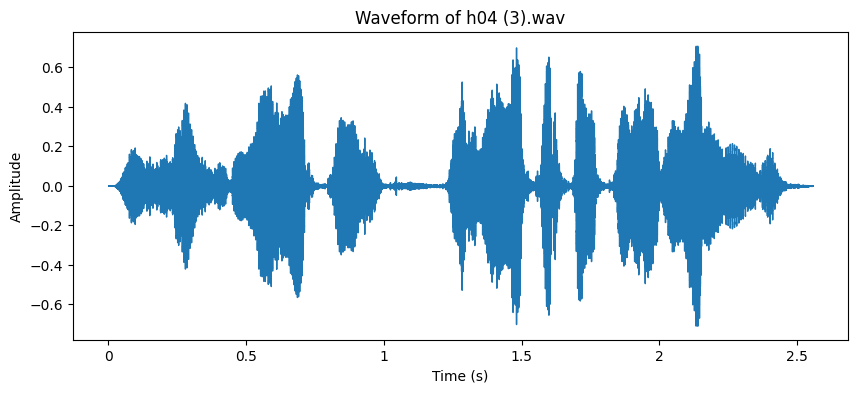

In [420]:
import matplotlib.pyplot as plt

# Plot the waveform of the first file
file_to_plot = metadata[0]['file_path']
y, sr = librosa.load(file_to_plot, sr=None)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform of {metadata[0]['file_name']}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

### Adding an *emotion* column

In [421]:
# Extract emotion labels from file names (the first letter of the file name indicates emotion)
df_metadata['emotion'] = df_metadata['file_name'].str[0]

# Map single-letter codes to emotion names
emotion_mapping = {
    'a': 'angry',
    'h': 'happy',
    's': 'sad',
    'd': 'disgust',
    'f': 'fear'
}
df_metadata['emotion'] = df_metadata['emotion'].map(emotion_mapping)

### Example of waveform for every emotion

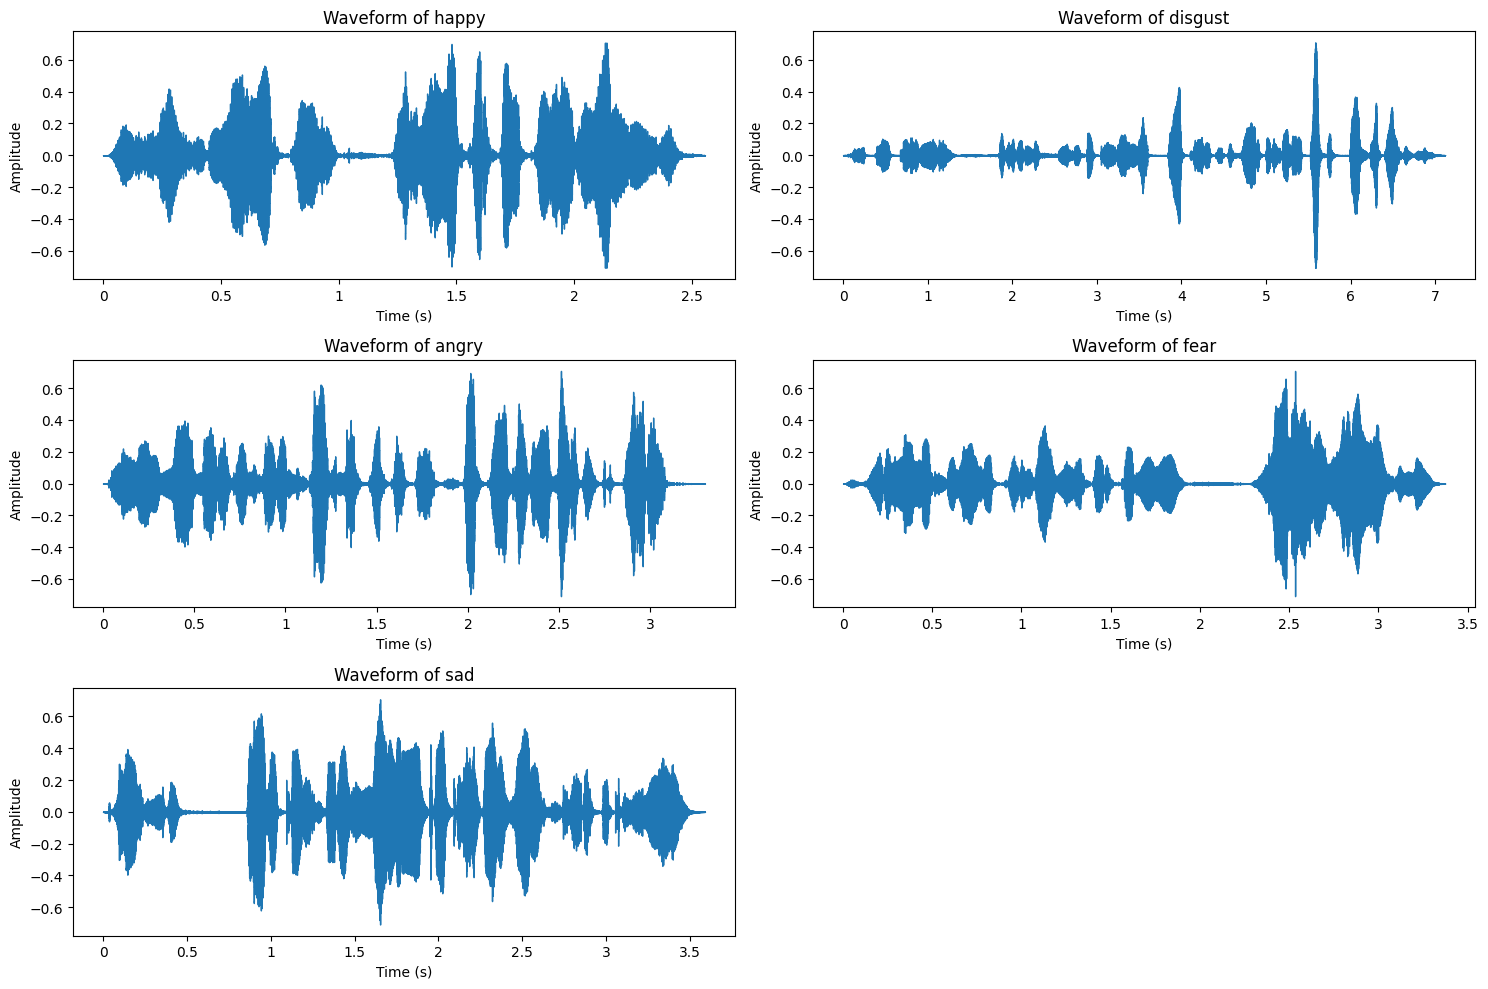

In [422]:
# Obtaining the unique emotions
emotions = df_metadata['emotion'].unique()
files_per_emotion = {}

# Select one file per emotion
for emotion in emotions:
    files_per_emotion[emotion] = df_metadata[df_metadata['emotion'] == emotion].iloc[0]['file_path']

# Create a figure to plot the waveforms
plt.figure(figsize=(15, 10))

for i, (emotion, file_path) in enumerate(files_per_emotion.items(), 1):
    y, sr = librosa.load(file_path, sr=None)
    plt.subplot(3, 2, i) 
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform of {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

### Histogram of audio durations

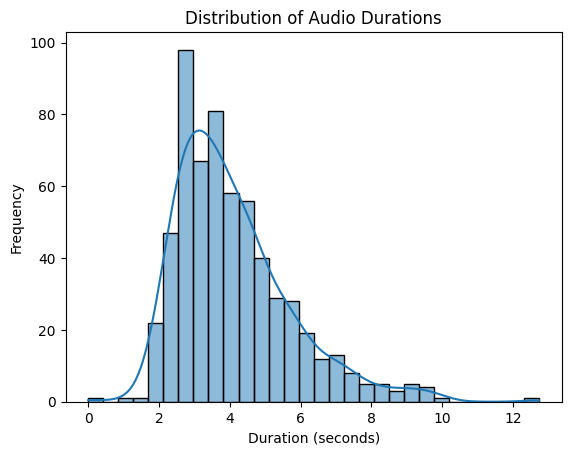

In [423]:
import seaborn as sns

# Histogram of durations
sns.histplot(df_metadata['duration_sec'], bins=30, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

We observe that there is an audio with a duration of 0 second, we remove it

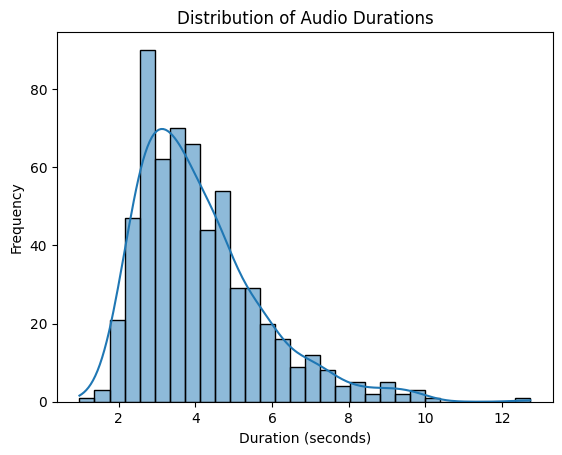

In [424]:
# Remove entries with a duration of 0.0 seconds
df_metadata = df_metadata[df_metadata['duration_sec'] > 0.0]
# Histogram of durations
sns.histplot(df_metadata['duration_sec'], bins=30, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

### Duration of the audio files by emotion
Table :

In [425]:
# Summarize duration by emotion
emotion_summary = df_metadata.groupby("emotion")["duration_sec"].describe()
emotion_summary.head(5)

,count,mean,std,min,25%,50%,75%,max
emotion,,,,,,,,
angry,121.0,3.585928,1.262586,1.531882,2.600000,3.376621,4.297891,7.410476
disgust,122.0,4.560497,1.419934,1.900000,3.473067,4.470556,5.470278,9.728277
fear,120.0,3.746690,1.483154,0.981179,2.727874,3.354490,4.533356,9.000000
happy,119.0,4.024161,1.550632,1.936508,2.892551,3.600000,4.665567,9.530476
sad,122.0,4.591546,2.049071,2.035828,3.174796,4.078628,4.986196,12.734853


Histograms :

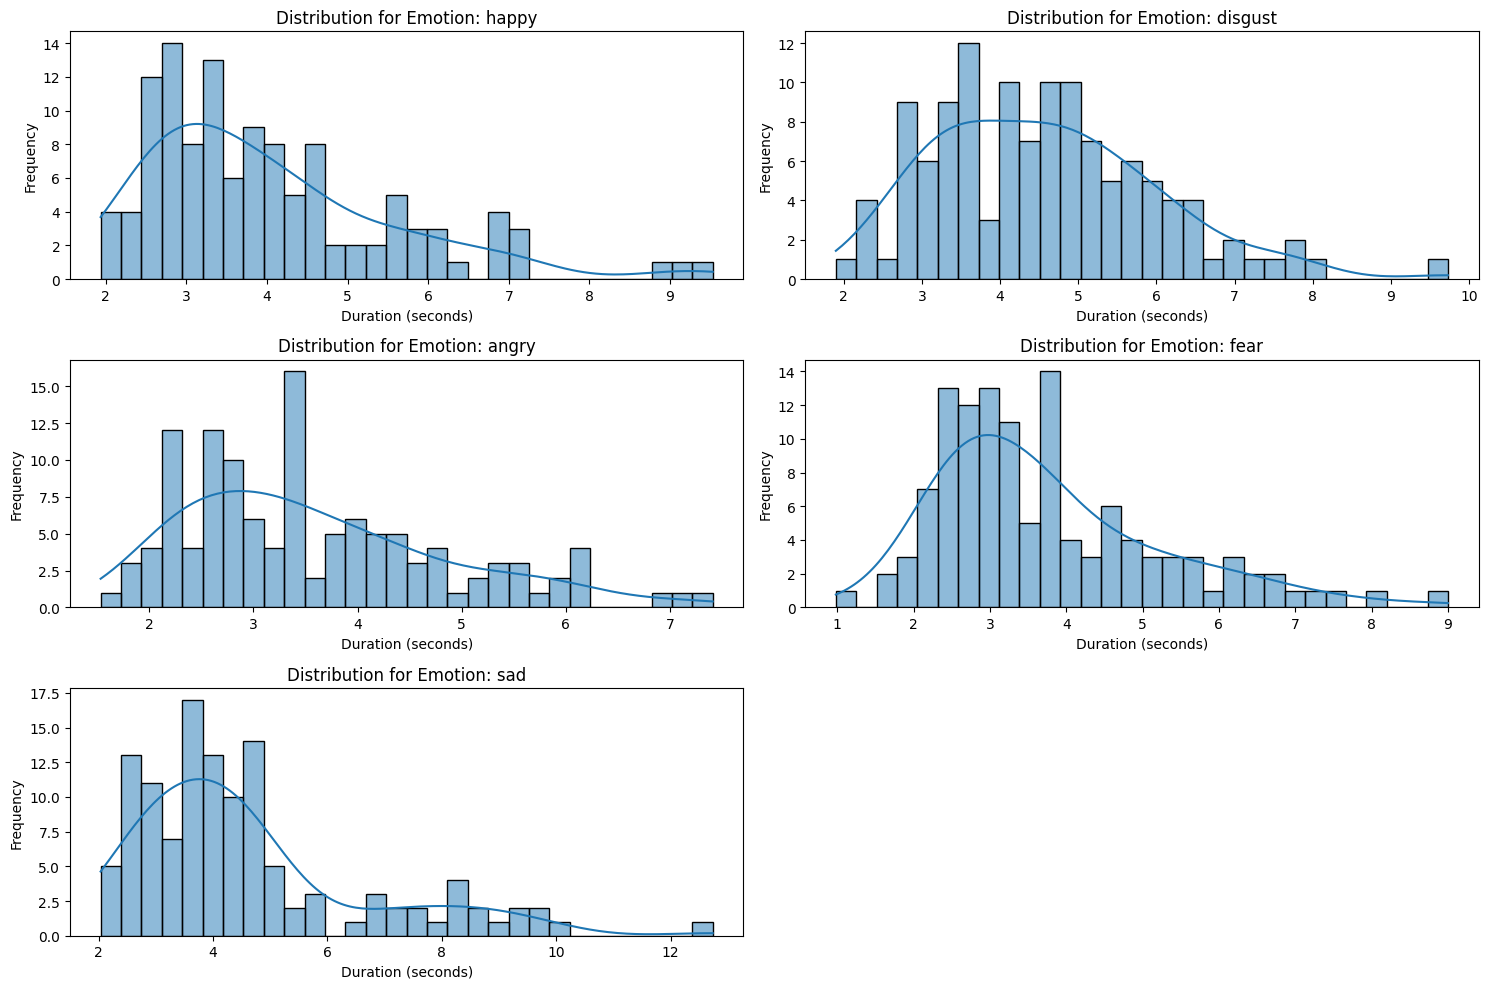

In [426]:
# Supposons que 'emotion' est une colonne dans df_metadata
categories = df_metadata['emotion'].unique()  # Obtenir les catégories uniques

# Créer une figure avec 5 plots (1 pour chaque catégorie)
plt.figure(figsize=(15, 10))  # Ajuster la taille globale

for i, category in enumerate(categories, 1):  # Boucle sur les catégories
    plt.subplot(3, 2, i)  # Disposer les plots en 3x2 (modifiez si nécessaire)
    sns.histplot(
        df_metadata[df_metadata['emotion'] == category]['duration_sec'],
        bins=30,
        kde=True
    )
    plt.title(f"Distribution for Emotion: {category}")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Frequency")

plt.tight_layout()  # Ajuster automatiquement l'espacement
plt.show()

We cannot observe important variation of duration according to emotion.

---

## 1.B - **Data processing**

### Noise Reduction

We reduce noise using the `noisereduce` package.

In [427]:
import librosa.display
import noisereduce as nr


# Function to preprocess a single audio file
def preprocess_audio(file_path, target_sr=None):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=target_sr)
    
    # Noise reduction (simple)
    noise_profile = y[:int(sr * 1)]

# Reduce noise
    y = nr.reduce_noise(y=y, sr=sr, y_noise=noise_profile)
    
    # Normalization
    y = librosa.util.normalize(y)
    
    return y, sr

### Mel spectogram
Mel spectrograms transform audio files into numeric representations using the Discrete Fourier Transform.

In [428]:
import numpy as np

# Function to convert a signal to a Mel Spectrogram
def audio_to_mel_spectrogram(y, sr, n_mels=128, fmax=8000):
    # Create Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Convert to log scale for better interpretability
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    return log_mel_spec

# Function to visualize a Mel Spectrogram
def plot_mel_spectrogram(mel_spec, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.show()

We create a column to store the mel spectrogram, and plot an example of a mel spectrogram for the first file.

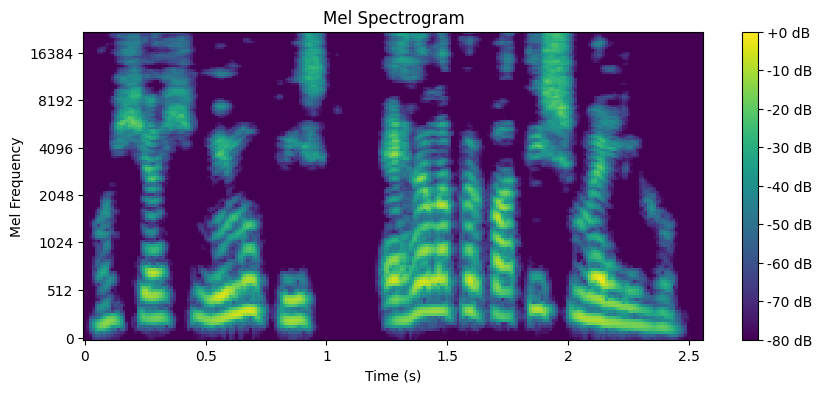

In [429]:
# We add a new column to store the Mel Spectrogram data
df_metadata['mel_spectrogram'] = None  # Initialize a column for spectrogram data
for index, row in df_metadata.iterrows():
    file_path = row['file_path']
    
    try:
        # Preprocess the audio
        y, sr = preprocess_audio(file_path)
                
        # Convert to Mel Spectrogram
        mel_spec = audio_to_mel_spectrogram(y, sr)
        
        # Store the Mel Spectrogram in the DataFrame
        df_metadata.at[index, 'mel_spectrogram'] = mel_spec

        # Visualize the spectrogram for the first file
        if index == 0:
            plot_mel_spectrogram(mel_spec, sr)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

We export all the Mel spectrograms plots and save them in the folder *processed_spectrogram* (avalaible on [GitHub](https://github.com/SigurdST/emotion_recognition)).

In [430]:
preprocessed_data = []
for name, mel_spec in zip(df_metadata['file_name'], df_metadata['mel_spectrogram']):
    if mel_spec is not None:
        preprocessed_data.append({
            "file_name": name,
            "mel_spectrogram": mel_spec
        })

output_dir = "plot_spectrograms"
os.makedirs(output_dir, exist_ok=True)

for data in preprocessed_data:
    file_name = data["file_name"].replace(".wav", ".png")
    mel_spec = data["mel_spectrogram"]
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram: {file_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, file_name))
    plt.close()

### Mean decibel values in the spectrograms for every emotion

In [431]:
mean_sum_db = 0
for spec in df_metadata['mel_spectrogram']:
    mean_sum_db += np.sum(spec)/spec.shape[1]
mean_sum_db /= len(df_metadata['mel_spectrogram'])
print(f"Mean sum of dB values: {mean_sum_db}")

# Créer une structure pour stocker les résultats
mean_sum_db_by_emotion = {}

# Calculer la mean sum pour chaque émotion
for emotion in df_metadata['emotion'].unique():
    # Filtrer les spectrogrammes pour l'émotion actuelle
    specs = df_metadata[df_metadata['emotion'] == emotion]['mel_spectrogram']
    
    # Initialiser la somme totale pour cette émotion
    total_sum_db = 0
    
    # Parcourir les spectrogrammes de l'émotion
    for spec in specs:
        total_sum_db += np.sum(spec) / spec.shape[1]
    
    # Calculer la moyenne pour cette émotion
    mean_sum_db_by_emotion[emotion] = total_sum_db / len(specs)

# Afficher les résultats
for emotion, mean_sum in mean_sum_db_by_emotion.items():
    print(f"Emotion: {emotion}, mean sum of dB values: {mean_sum}")

Mean sum of dB values: -8450.106890589786
Emotion: happy, mean sum of dB values: -8413.536775910055
Emotion: disgust, mean sum of dB values: -8554.73667156356
Emotion: angry, mean sum of dB values: -8281.237260056003
Emotion: fear, mean sum of dB values: -8387.866761152081
Emotion: sad, mean sum of dB values: -8609.853211861911


We do not observe a significant difference in the means.

---

---

# 2 - ***Convolutional Neural Network***
### Data preparation to modelisation
We prepare the data for the neural network by labeling the target variable and creating training and test sets.

In [779]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode emotions
label_encoder = LabelEncoder()
df_metadata['emotion_encoded'] = label_encoder.fit_transform(df_metadata['emotion'])

# Split the data
train_df, test_df = train_test_split(df_metadata, test_size=0.2, stratify=df_metadata['emotion_encoded'], random_state=42)

# Display the mapping between labels and emotions
emotion_label_mapping = {label: emotion for label, emotion in enumerate(label_encoder.classes_)}
print("Mapping between labels and emotions:", emotion_label_mapping)

Mapping between labels and emotions: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad'}


We create custom `PyTorch` Dataset class that wraps a DataFrame containing Mel spectrograms and their corresponding labels.

In [780]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# Class to convert the DataFrame to a PyTorch Dataset with tensors
class MelSpectrogramDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        mel_spectrogram = row['mel_spectrogram'] 
        label = row['emotion_encoded']

        # Normalize the spectrogram
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()

        # Convert the NumPy array to PyTorch tensors
        mel_tensor = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return mel_tensor, label_tensor


# Create the datasets
train_dataset = MelSpectrogramDataset(train_df)
test_dataset = MelSpectrogramDataset(test_df)

### Function to train and evaluate our CNNs

In [781]:
def train_model(model, train_loader, learning_rate, num_epochs):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        average_loss = running_loss / len(train_loader)
        train_losses.append(average_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")

    return train_losses

In [782]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def eval_and_plot(model, test_loader, train_losses=None):

    model.eval()
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
  
    if train_losses:
        plt.plot(train_losses, label='Training Loss')
        plt.title('Training Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

The fist issue is that all the spectrograms don't have the same size. To adapt to this, we try two methods :
- CNNs with batch size of 1
- CNNs with resized data

We will then compare which method is better.

The second issue is that we have a small dataset (604 audio files). To adapt to this we will try to increase the size of our dataset.

---

## 2.A - **CNNs with batch of size 1**

### 2.A.1 - *3 Layers*

In [799]:
# Create the data loaders with a batch size of 1
train_loader_bs1 = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader_bs1 = DataLoader(test_dataset, batch_size=1, shuffle=False)

# CNN model with 3 layers
class EmotionCNN3layBS1(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN3layBS1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Number of classes
num_classes = len(label_encoder.classes_)


### Train with learning rate = 0.001

In [ ]:
model_bs1_3lay1 = EmotionCNN3layBS1(num_classes=num_classes)
train_losses = train_model(model_bs1_3lay1, train_loader_bs1, 0.001, 200)

Epoch 1/200, Loss: 1.6149
Epoch 2/200, Loss: 1.6124
Epoch 3/200, Loss: 1.6133
Epoch 4/200, Loss: 1.6096
Epoch 5/200, Loss: 1.6106
Epoch 6/200, Loss: 1.5935
Epoch 7/200, Loss: 1.5760
Epoch 8/200, Loss: 1.5673
Epoch 9/200, Loss: 1.5476
Epoch 10/200, Loss: 1.5245
Epoch 11/200, Loss: 1.4889
Epoch 12/200, Loss: 1.4747
Epoch 13/200, Loss: 1.4489
Epoch 14/200, Loss: 1.3907
Epoch 15/200, Loss: 1.3445
Epoch 16/200, Loss: 1.3576
Epoch 17/200, Loss: 1.3107
Epoch 18/200, Loss: 1.3169
Epoch 19/200, Loss: 1.2598
Epoch 20/200, Loss: 1.2702
Epoch 21/200, Loss: 1.2380
Epoch 22/200, Loss: 1.2179
Epoch 23/200, Loss: 1.2241
Epoch 24/200, Loss: 1.2132
Epoch 25/200, Loss: 1.1759
Epoch 26/200, Loss: 1.1967
Epoch 27/200, Loss: 1.1593
Epoch 28/200, Loss: 1.1606
Epoch 29/200, Loss: 1.1100
Epoch 30/200, Loss: 1.1201
Epoch 31/200, Loss: 1.1175
Epoch 32/200, Loss: 1.1088
Epoch 33/200, Loss: 1.1008
Epoch 34/200, Loss: 1.1056
Epoch 35/200, Loss: 1.0880
Epoch 36/200, Loss: 1.0959
Epoch 37/200, Loss: 1.0520
Epoch 38/2

Test Accuracy: 66.12%
Precision: 69.29%
Recall: 66.12%


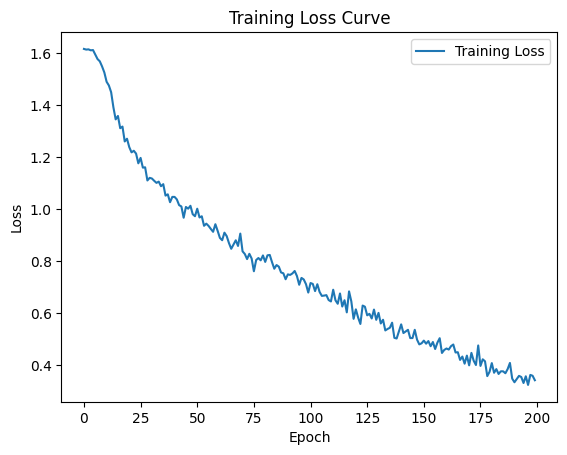

In [439]:
eval_and_plot(model_bs1_3lay1, test_loader_bs1, train_losses)

### Train with learning rate = 0.0001

In [ ]:
model_bs1_3lay2 = EmotionCNN3layBS1(num_classes=num_classes)
train_losses = train_model(model_bs1_3lay2, train_loader_bs1, 0.0001, 600)

Epoch 1/400, Loss: 1.6142
Epoch 2/400, Loss: 1.6120
Epoch 3/400, Loss: 1.6109
Epoch 4/400, Loss: 1.6104
Epoch 5/400, Loss: 1.6106
Epoch 6/400, Loss: 1.6047
Epoch 7/400, Loss: 1.6038
Epoch 8/400, Loss: 1.6003
Epoch 9/400, Loss: 1.5953
Epoch 10/400, Loss: 1.5880
Epoch 11/400, Loss: 1.5813
Epoch 12/400, Loss: 1.5798
Epoch 13/400, Loss: 1.5648
Epoch 14/400, Loss: 1.5657
Epoch 15/400, Loss: 1.5664
Epoch 16/400, Loss: 1.5608
Epoch 17/400, Loss: 1.5528
Epoch 18/400, Loss: 1.5546
Epoch 19/400, Loss: 1.5550
Epoch 20/400, Loss: 1.5517
Epoch 21/400, Loss: 1.5542
Epoch 22/400, Loss: 1.5478
Epoch 23/400, Loss: 1.5505
Epoch 24/400, Loss: 1.5511
Epoch 25/400, Loss: 1.5567
Epoch 26/400, Loss: 1.5419
Epoch 27/400, Loss: 1.5440
Epoch 28/400, Loss: 1.5489
Epoch 29/400, Loss: 1.5373
Epoch 30/400, Loss: 1.5359
Epoch 31/400, Loss: 1.5322
Epoch 32/400, Loss: 1.5352
Epoch 33/400, Loss: 1.5332
Epoch 34/400, Loss: 1.5370
Epoch 35/400, Loss: 1.5388
Epoch 36/400, Loss: 1.5249
Epoch 37/400, Loss: 1.5257
Epoch 38/4

Test Accuracy: 51.24%
Precision: 48.27%
Recall: 51.24%


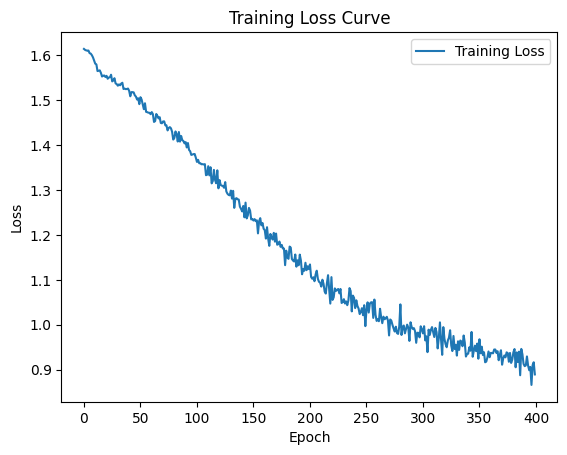

In [441]:
eval_and_plot(model_bs1_3lay2, test_loader_bs1, train_losses)

### 2.A.2 - *4 Layers*

In [796]:
# CNN model with 4 layers
class EmotionCNN4layBS1(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN4layBS1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.fc = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### Train with learning rate = 0.001

In [443]:
model_bs1_4lay1 = EmotionCNN4layBS1(num_classes=num_classes)
train_losses = train_model(model_bs1_4lay1, train_loader_bs1, 0.001, 40)

Epoch 1/50, Loss: 1.6159
Epoch 2/50, Loss: 1.6120
Epoch 3/50, Loss: 1.5902
Epoch 4/50, Loss: 1.4587
Epoch 5/50, Loss: 1.3728
Epoch 6/50, Loss: 1.2734
Epoch 7/50, Loss: 1.2485
Epoch 8/50, Loss: 1.2246
Epoch 9/50, Loss: 1.1814
Epoch 10/50, Loss: 1.1688
Epoch 11/50, Loss: 1.1408
Epoch 12/50, Loss: 1.1264
Epoch 13/50, Loss: 1.0902
Epoch 14/50, Loss: 1.0449
Epoch 15/50, Loss: 1.0221
Epoch 16/50, Loss: 0.9801
Epoch 17/50, Loss: 0.9625
Epoch 18/50, Loss: 0.9326
Epoch 19/50, Loss: 0.9231
Epoch 20/50, Loss: 0.8802
Epoch 21/50, Loss: 0.8341
Epoch 22/50, Loss: 0.7779
Epoch 23/50, Loss: 0.7579
Epoch 24/50, Loss: 0.7257
Epoch 25/50, Loss: 0.6931
Epoch 26/50, Loss: 0.6541
Epoch 27/50, Loss: 0.6219
Epoch 28/50, Loss: 0.6207
Epoch 29/50, Loss: 0.5302
Epoch 30/50, Loss: 0.4982
Epoch 31/50, Loss: 0.4405
Epoch 32/50, Loss: 0.4840
Epoch 33/50, Loss: 0.3998
Epoch 34/50, Loss: 0.4288
Epoch 35/50, Loss: 0.3355
Epoch 36/50, Loss: 0.3123
Epoch 37/50, Loss: 0.3415
Epoch 38/50, Loss: 0.2836
Epoch 39/50, Loss: 0.

Test Accuracy: 65.29%
Precision: 67.07%
Recall: 65.29%


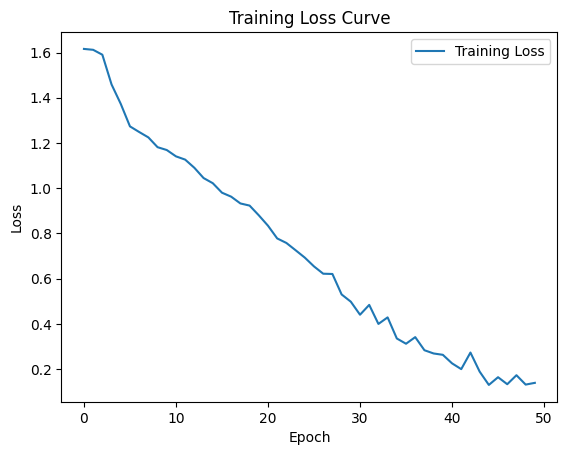

In [ ]:
# Evaluate the model
eval_and_plot(model_bs1_4lay1, test_loader_bs1, train_losses)

### Train with learning rate = 0.0001

In [ ]:
model_bs1_4lay2 = EmotionCNN4layBS1(num_classes=num_classes)
train_losses = train_model(model_bs1_4lay2, train_loader_bs1, 0.0001, 150)

Epoch 1/100, Loss: 1.6129
Epoch 2/100, Loss: 1.6090
Epoch 3/100, Loss: 1.6027
Epoch 4/100, Loss: 1.6030
Epoch 5/100, Loss: 1.5967
Epoch 6/100, Loss: 1.5778
Epoch 7/100, Loss: 1.5612
Epoch 8/100, Loss: 1.5352
Epoch 9/100, Loss: 1.5095
Epoch 10/100, Loss: 1.4692
Epoch 11/100, Loss: 1.4361
Epoch 12/100, Loss: 1.4227
Epoch 13/100, Loss: 1.3930
Epoch 14/100, Loss: 1.3731
Epoch 15/100, Loss: 1.3779
Epoch 16/100, Loss: 1.3286
Epoch 17/100, Loss: 1.3285
Epoch 18/100, Loss: 1.2918
Epoch 19/100, Loss: 1.2930
Epoch 20/100, Loss: 1.2618
Epoch 21/100, Loss: 1.2729
Epoch 22/100, Loss: 1.2468
Epoch 23/100, Loss: 1.2459
Epoch 24/100, Loss: 1.2327
Epoch 25/100, Loss: 1.2367
Epoch 26/100, Loss: 1.2153
Epoch 27/100, Loss: 1.2107
Epoch 28/100, Loss: 1.1801
Epoch 29/100, Loss: 1.1955
Epoch 30/100, Loss: 1.1644
Epoch 31/100, Loss: 1.1727
Epoch 32/100, Loss: 1.1335
Epoch 33/100, Loss: 1.1218
Epoch 34/100, Loss: 1.1320
Epoch 35/100, Loss: 1.1221
Epoch 36/100, Loss: 1.1061
Epoch 37/100, Loss: 1.1188
Epoch 38/1

Test Accuracy: 20.66%
Precision: 4.27%
Recall: 20.66%


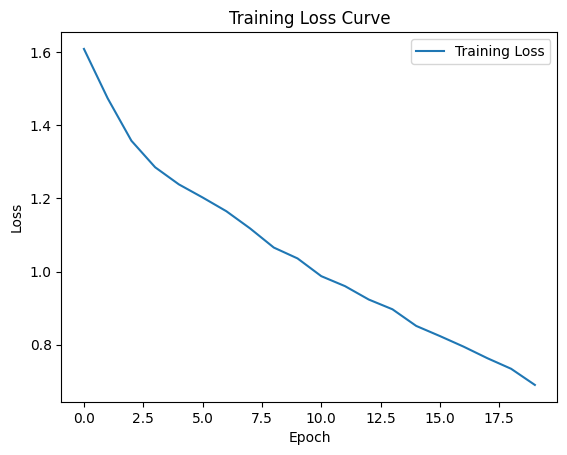

In [785]:
eval_and_plot(model_bs1_4lay2, test_loader_bs1, train_losses)

---

## 2.B - **CNNs with resized spectrograms**

### 2.B.1 - *Resize the Mel spectrogram to size $128\times256$ using padding and interpolation method*

In [595]:
# Class to create a resized Mel Spectrogram dataset with tensors
class MelSpectrogramDatasetResized(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        mel_spectrogram = row['mel_spectrogram'] 
        label = row['emotion_encoded']
        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()
        mel_spectrogram = self._resize_mel_spectrogram(mel_spectrogram)
        mel_tensor = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return mel_tensor, label_tensor

    def _resize_mel_spectrogram(self, mel_spectrogram):

        target_size = 256

        # If spectrogram width is smaller than target, pad with zeros
        if mel_spectrogram.shape[1] < target_size:
            padding = target_size - mel_spectrogram.shape[1]
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, padding)), mode='constant')

        # If spectrogram width is larger than target, interpolate
        elif mel_spectrogram.shape[1] > target_size:
            mel_spectrogram = librosa.resample(
                mel_spectrogram,
                orig_sr=mel_spectrogram.shape[1],
                target_sr=target_size)

        return mel_spectrogram
    
# Create the datasets
train_dataset_resized = MelSpectrogramDatasetResized(train_df)
test_dataset_resized = MelSpectrogramDatasetResized(test_df)

### 2.B.2 - *3 layers CNN*

In [596]:
# Create the data loaders with a batch size of 8
train_loader_res = DataLoader(train_dataset_resized, batch_size=8, shuffle=True)
test_loader_res = DataLoader(test_dataset_resized, batch_size=8, shuffle=False)

class EmotionCNN3lay_res(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN3lay_res, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))
        self.fc = nn.Linear(64 * 16 * 32, num_classes)
        self.dropout = nn.Dropout(0.75)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### Train with lr = 0.001

In [ ]:
model_bs1_3lay_res2 = EmotionCNN3lay_res(num_classes=num_classes)
train_losses = train_model(model_bs1_3lay_res2, train_loader_res, 0.001, 25)

Epoch 1/20, Loss: 5.0994
Epoch 2/20, Loss: 3.4102
Epoch 3/20, Loss: 2.1627
Epoch 4/20, Loss: 2.2991
Epoch 5/20, Loss: 1.9162
Epoch 6/20, Loss: 1.6835
Epoch 7/20, Loss: 1.4521
Epoch 8/20, Loss: 1.1123
Epoch 9/20, Loss: 1.5511
Epoch 10/20, Loss: 0.9803
Epoch 11/20, Loss: 0.9256
Epoch 12/20, Loss: 0.8386
Epoch 13/20, Loss: 0.5067
Epoch 14/20, Loss: 0.6260
Epoch 15/20, Loss: 0.6172
Epoch 16/20, Loss: 0.4925
Epoch 17/20, Loss: 0.4552
Epoch 18/20, Loss: 0.3508
Epoch 19/20, Loss: 0.2202
Epoch 20/20, Loss: 0.5615


Test Accuracy: 48.76%
Precision: 49.72%
Recall: 48.76%


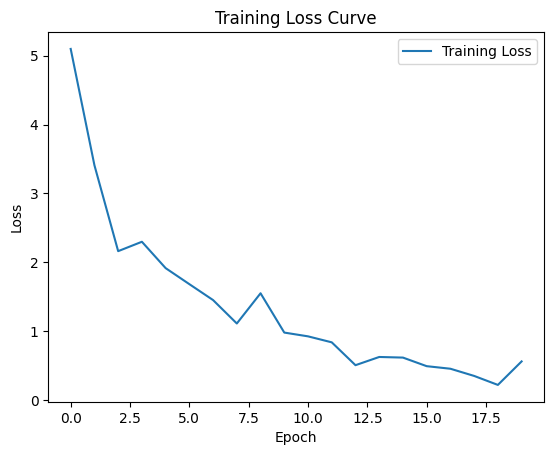

In [ ]:
eval_and_plot(model_bs1_3lay_res2, test_loader_res, train_losses)

### Train with lr = 0.0001

In [597]:
model_bs1_3lay_res1 = EmotionCNN3lay_res(num_classes=num_classes)
train_losses = train_model(model_bs1_3lay_res1, train_loader_res, 0.0001, 15)

Epoch 1/10, Loss: 2.1824
Epoch 2/10, Loss: 1.5860
Epoch 3/10, Loss: 1.2431
Epoch 4/10, Loss: 1.0337
Epoch 5/10, Loss: 0.8771
Epoch 6/10, Loss: 0.8220
Epoch 7/10, Loss: 0.7012
Epoch 8/10, Loss: 0.6041
Epoch 9/10, Loss: 0.5040
Epoch 10/10, Loss: 0.4690


Test Accuracy: 45.45%
Precision: 48.79%
Recall: 45.45%


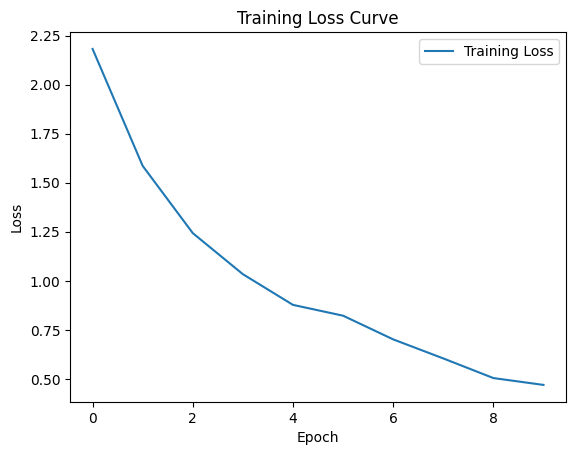

In [598]:
eval_and_plot(model_bs1_3lay_res1, test_loader_res, train_losses)

### 2.B.3 - *4 layers CNN*

In [605]:
class EmotionCNN4lay_res(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN4lay_res, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(128 * 8 * 16, num_classes)  # Adjust based on final output shape of conv layers

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x



### Train with learning rate = 0.001

In [ ]:
model_bs1_4lay_res2 = EmotionCNN4lay_res(num_classes=num_classes)
train_losses = train_model(model_bs1_4lay_res2, train_loader_res, 0.001, 10)

Epoch 1/10, Loss: 4.6021
Epoch 2/10, Loss: 2.0140
Epoch 3/10, Loss: 1.6664
Epoch 4/10, Loss: 1.7876
Epoch 5/10, Loss: 0.9833
Epoch 6/10, Loss: 0.8151
Epoch 7/10, Loss: 0.6167
Epoch 8/10, Loss: 0.3932
Epoch 9/10, Loss: 0.4366
Epoch 10/10, Loss: 0.2491


Test Accuracy: 57.02%
Precision: 48.45%
Recall: 57.02%


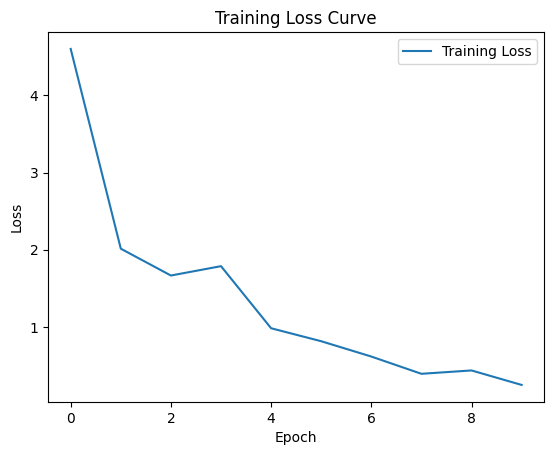

In [609]:
eval_and_plot(model_bs1_4lay_res2, test_loader_res, train_losses)

### Train with learning rate = 0.0001

In [606]:
model_bs1_4lay_res1 = EmotionCNN4lay_res(num_classes=num_classes)
train_losses = train_model(model_bs1_4lay_res1, train_loader_res, 0.0001, 10)

Epoch 1/10, Loss: 1.7797
Epoch 2/10, Loss: 1.1630
Epoch 3/10, Loss: 0.9044
Epoch 4/10, Loss: 0.6369
Epoch 5/10, Loss: 0.4747
Epoch 6/10, Loss: 0.3760
Epoch 7/10, Loss: 0.2900
Epoch 8/10, Loss: 0.2281
Epoch 9/10, Loss: 0.1636
Epoch 10/10, Loss: 0.1245


Test Accuracy: 54.55%
Precision: 57.17%
Recall: 54.55%


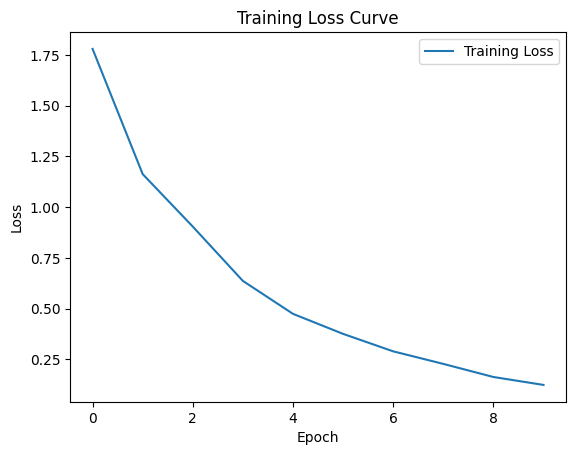

In [607]:
eval_and_plot(model_bs1_4lay_res1, test_loader_res, train_losses)

---

## 2.C - **CNNs on artificial data**

### 2.C.1 - *Data augmentation techniques*

We create 4 fonctions that can modify our Mel spectrograms to create new data.

In [770]:
import random

# Function to add noise to the spectrogram
def add_noise(spectrogram, noise_level=0.01):
    noise = np.random.normal(0, noise_level, spectrogram.shape)
    return spectrogram + noise

# Function to shift the pitch of the spectrogram
def pitch_shift(spectrogram, sr, n_steps):
    return librosa.effects.pitch_shift(spectrogram, sr=sr, n_steps=n_steps)

# Function to apply a frequency mask
def freq_mask(spectrogram, freq_mask_param):
    spec = spectrogram.copy()
    f = random.randint(0, freq_mask_param)
    f0 = random.randint(0, spec.shape[0] - f)
    spec[f0:f0 + f, :] = 0
    return spec

# Function to apply a time mask
def time_mask(spectrogram, time_mask_param):
    spec = spectrogram.copy()
    t = random.randint(0, time_mask_param)
    t0 = random.randint(0, spec.shape[1] - t)
    spec[:, t0:t0 + t] = 0
    return spec

# We apply the functions on the train set
augmented_data = []

for spec in train_df['mel_spectrogram']:

    for i in range(10):

        augmented = spec.copy()
        
        # Apply random transformations
        if random.random() < 0.6:
            augmented = add_noise(augmented)
        if random.random() < 0.6:
            n_steps = random.uniform(-4, 4)
            augmented = librosa.db_to_power(augmented)
            augmented = pitch_shift(augmented, sr, n_steps)
            augmented = librosa.power_to_db(augmented)
        if random.random() < 0.6:
            freq_mask_param = random.randint(10, 30)
            augmented = freq_mask(augmented, freq_mask_param)
        if random.random() < 0.6:
            time_mask_param = random.randint(10, 50)
            augmented = time_mask(augmented, time_mask_param)

        augmented_data.append(augmented)

We create a dataset with the augmented_data and the correponding label and convert them to tensor.

In [771]:
augmented_emotion = train_df['emotion'].values.repeat(10)

train_df_augmented = pd.DataFrame({
    'mel_spectrogram': augmented_data,
    'emotion': augmented_emotion
})

train_df_augmented['emotion_encoded'] = label_encoder.transform(train_df_augmented['emotion'])
train_dataset_augmented = MelSpectrogramDataset(train_df_augmented)
train_loader_augmented_bs1 = DataLoader(train_dataset_augmented, batch_size=1, shuffle=True)


### 2.C.2 - *CNN with batch size of 1*

We only do 4 layers because cit converges faster and computation are slow.

In [ ]:
model_bs1_4lay_aug = EmotionCNN4layBS1(num_classes=num_classes)
train_losses = train_model(model_bs1_4lay_aug, train_loader_augmented_bs1, 0.001, 50)

Epoch 1/50, Loss: 1.5708
Epoch 2/50, Loss: 1.4179
Epoch 3/50, Loss: 1.3103
Epoch 4/50, Loss: 1.2482
Epoch 5/50, Loss: 1.2019
Epoch 6/50, Loss: 1.1502
Epoch 7/50, Loss: 1.1152
Epoch 8/50, Loss: 1.0827
Epoch 9/50, Loss: 1.0460
Epoch 10/50, Loss: 0.9817
Epoch 11/50, Loss: 0.9404
Epoch 12/50, Loss: 0.8928
Epoch 13/50, Loss: 0.8525
Epoch 14/50, Loss: 0.8025
Epoch 15/50, Loss: 0.7718
Epoch 16/50, Loss: 0.7365
Epoch 17/50, Loss: 0.6883
Epoch 18/50, Loss: 0.6490
Epoch 19/50, Loss: 0.6000
Epoch 20/50, Loss: 0.5760
Epoch 21/50, Loss: 0.5396
Epoch 22/50, Loss: 0.5027
Epoch 23/50, Loss: 0.4663
Epoch 24/50, Loss: 0.4302
Epoch 25/50, Loss: 0.4091
Epoch 26/50, Loss: 0.3781
Epoch 27/50, Loss: 0.3524
Epoch 28/50, Loss: 0.3445
Epoch 29/50, Loss: 0.3099
Epoch 30/50, Loss: 0.3040
Epoch 31/50, Loss: 0.2868
Epoch 32/50, Loss: 0.2641
Epoch 33/50, Loss: 0.2503
Epoch 34/50, Loss: 0.2458
Epoch 35/50, Loss: 0.2385


Test Accuracy: 49.59%
Precision: 52.75%
Recall: 49.59%


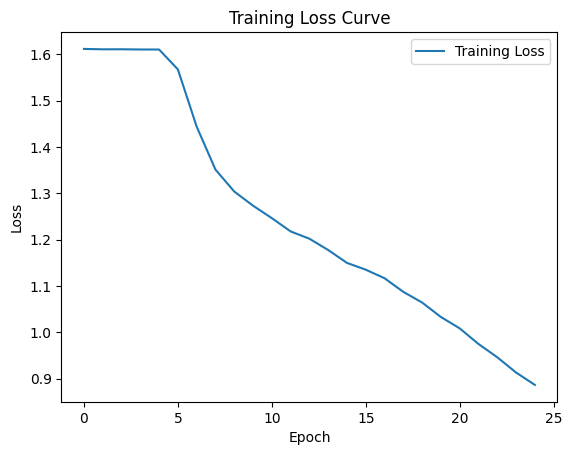

In [800]:
eval_and_plot(model_bs1_4lay_aug, test_loader_bs1, train_losses)

### 2.C.3 - *CNN with resized data*

In [788]:
train_dataset_augmented_resized = MelSpectrogramDatasetResized(train_df_augmented)
train_loader_augmented_res = DataLoader(train_dataset_augmented_resized, batch_size=16, shuffle=True)

class EmotionCNN4lay_res_aug(nn.Module):
    def __init__(self, num_classes):
        super(EmotionCNN4lay_res_aug, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(128 * 8 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

### Train with learning rate = 0.001

In [789]:
model_bs1_4lay_res_aug = EmotionCNN4lay_res_aug(num_classes=num_classes)
train_losses = train_model(model_bs1_4lay_res_aug, train_loader_augmented_res, 0.001, 10)

Epoch 1/10, Loss: 2.3399
Epoch 2/10, Loss: 1.5119
Epoch 3/10, Loss: 1.0456
Epoch 4/10, Loss: 0.7360
Epoch 5/10, Loss: 0.4906
Epoch 6/10, Loss: 0.3368
Epoch 7/10, Loss: 0.2290
Epoch 8/10, Loss: 0.1418
Epoch 9/10, Loss: 0.1016
Epoch 10/10, Loss: 0.0875


Test Accuracy: 52.07%
Precision: 54.60%
Recall: 52.07%


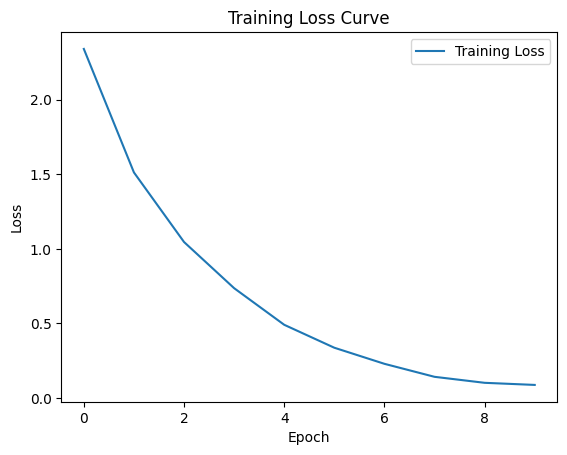

In [790]:
eval_and_plot(model_bs1_4lay_res_aug, test_loader_res, train_losses)

### Train with learning rate = 0.0001

In [792]:
model_bs1_4lay_res_aug2 = EmotionCNN4lay_res_aug(num_classes=num_classes)
train_losses = train_model(model_bs1_4lay_res_aug2, train_loader_augmented_res, 0.0001, 10)

Epoch 1/10, Loss: 1.4929
Epoch 2/10, Loss: 1.0413
Epoch 3/10, Loss: 0.7808
Epoch 4/10, Loss: 0.5894
Epoch 5/10, Loss: 0.4673
Epoch 6/10, Loss: 0.3532
Epoch 7/10, Loss: 0.2803
Epoch 8/10, Loss: 0.2149
Epoch 9/10, Loss: 0.1759
Epoch 10/10, Loss: 0.1548


Test Accuracy: 56.20%
Precision: 59.28%
Recall: 56.20%


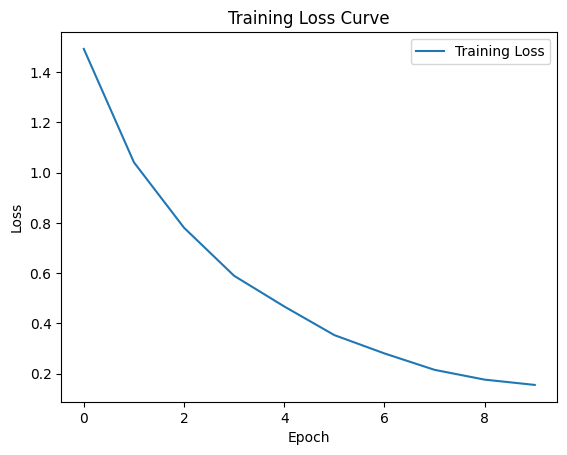

In [793]:
eval_and_plot(model_bs1_4lay_res_aug2, test_loader_res, train_losses)

---
---